# Hyperparameter optimization: BERT embeddings

Grand et al data

Hyperparameter optimization on a development set.

# Reading the data

## BERT

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
num_randseeds = 3
feature_dim = 1024

In [3]:
bert_large_vecs_path = "bert-large-uncased.npz"

word_vectors = {}
data = np.load(bert_large_vecs_path)

for word in data:
    vector = data[word]
    if ' ' in word:
        first, second = word.split()
        if 'north' in first and 'dakota' in second:
            word = first + '_' + second
            print(word)
            word_vectors[word] = vector
        else:
            word = first + '-' + second
            print(word)
            word_vectors[word] = vector
    else:
        word_vectors[word] = vector

north-carolina
ping-pong
hong-kong
north_dakota
rhode-island
new-york
south-dakota
los-angeles
west-virginia
new-jersey
san-francisco
new-hampshire
south-carolina
new-mexico


## Grand features

In [4]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Function for reading a specific Grand dataset

In [5]:
# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    nspeakers = len(df.columns) -1
    df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

# Function for running crossvalidation

In [6]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir, 
                                                                                            grandfeatures_df)


            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = np.random.randint(method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"],
                                                                                       random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


# Function for aggregating crossvalidation results

We assume results that are dictionaries. 

First, a function for aggregating results by particular labels, into a single dictionary. For example, when results are aggregated by category and feature, the result will be a dictionary whose keys are category/feature tuples, and the values are lists of result dictionaries. 

Second, a function that computes mean, median, and standard deviation, over a list of result dictionaries, for a given labels.

In [7]:
from collections import defaultdict
import statistics

# given a list of results dictionaries, 
# group them by the given dictionary keys
def eval_aggregate_by(evals, keylabels):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        key = tuple([str(e[k]) for k in keylabels])
        bydataset_eval[ key ].append(e)
        
    return bydataset_eval


# given a list of results dictionaries,
# compute mean, median and standard deviation over values for a particular key
def eval_summary_by(evals, keylabel):
    vals = [e[keylabel] for e in evals if e[keylabel] is not None]
    
    return (statistics.mean(vals), statistics.median(vals), statistics.stdev(vals))

# given a dictionary of results (parameters -> result dictionary list),
# * for each parameter setting, aggregate by cateogy and feature
# * for each category/feature, compute mean ocp and mse values
# * for the parameter setting, compute mean and sd ocp and mse over all category/feature pairs
def eval_hyper(results, parameternames):
    # output dictionary
    results_byparam = [ ]

    # iterate over parameter settings
    for theseresults in results.values():
        # extract parameters
        this_dict = dict([(par, theseresults[0][par]) for par in parameternames])
        
        # aggregate by condition = by category and feature
        results_bycond = eval_aggregate_by(theseresults,["category", "feature"])
        
        # compute mean ocp and mse values.
        # ocp: we use mean for each condition.
        # mse: we use median for each condition
        ocps = [eval_summary_by(cond_results, "ocp")[0] for cond_results in results_bycond.values()]
        mses = [eval_summary_by(cond_results, "mse")[1] for cond_results in results_bycond.values()]

        # compute mean and standard deviation over ocps and mses
        this_dict["ocp_mean"] = statistics.mean(ocps)
        this_dict["ocp_sd"] = statistics.stdev(ocps)
        this_dict["msemed_mean"] = statistics.mean(mses)
        this_dict["msemed_sd"] = statistics.stdev(mses)
        
        results_byparam.append(this_dict)
        
    return results_byparam


# Making a development set

In [8]:
filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]

import random
random.seed(789)
devset = random.sample(filenames, 6)
[ filename[:-4].split("_") for filename in devset]

[['cities', 'danger'],
 ['states', 'political'],
 ['animals', 'wetness'],
 ['cities', 'intelligence'],
 ['animals', 'weight'],
 ['names', 'age']]

# Determining hyperparameters

## Fitted dimensions with seeds as words: offset, jitter

First experiments looked like there was a lot of variance in result with different random seeds. To check into this, we run the hyperparameter tests n times with different random seeds. We then look at mean and standard deviation of the two measures we focus on: mean OC_p and median MSE.

In [9]:
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=20)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(oval, jval, ocp_mean, mse_med)
            

            for r in theseresults:
                r.update({"offset":oval, "j": jval})
                results[ (str(oval), str(jval))].append(r)
    


0.1 True 0.5386927129833723 564.4404335440773
0.2 True 0.4896513050498524 676.047684084766
0.3 True 0.5095158906821176 1097.4809916562717
0.4 True 0.5293094110162085 842.0829663526972
0.5 True 0.49669145139840387 919.9508880741832
0.6 True 0.4987071478566379 1165.0149160828669
0.7 True 0.5161036789302086 1077.4469033755365
0.7999999999999999 True 0.505855889500114 945.7686744875672
0.8999999999999999 True 0.5157164544740486 813.2391083760126
0.9999999999999999 True 0.5115338813081937 1023.1857459236691
1.0999999999999999 True 0.5103214692413723 778.56433330148
1.2 True 0.5078341047730314 992.3335947043425
1.3 True 0.48674367612059927 822.2131269280803
1.4 True 0.5011778693314841 814.1914924324144
1.5 True 0.5136132580554715 990.7814290825065
1.5999999999999999 True 0.5129299921147437 1087.967707623437
1.7 True 0.5185691990103511 954.360478947867
1.8 True 0.5085617529473879 1048.6320768202183
1.9 True 0.5196551191480563 750.5159467527214
2.0 True 0.49933546653977967 976.1731305906374
0.

In [10]:
df = pd.DataFrame(eval_hyper(results, ["offset", "j"]))
df.head()


,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.1,True,0.528786,0.031751,403.440277,241.692239
1,0.2,True,0.515936,0.037784,363.614069,218.643055
2,0.3,True,0.515120,0.031178,356.532935,227.038393
3,0.4,True,0.530575,0.031314,440.331132,342.837467
4,0.5,True,0.508114,0.045041,441.524259,325.040179


We plot mean OC_P values, with standard deviation. The differences in result are small compared to the error bars: It basically doesn't matter which value we pick. 

<AxesSubplot: xlabel='offset'>

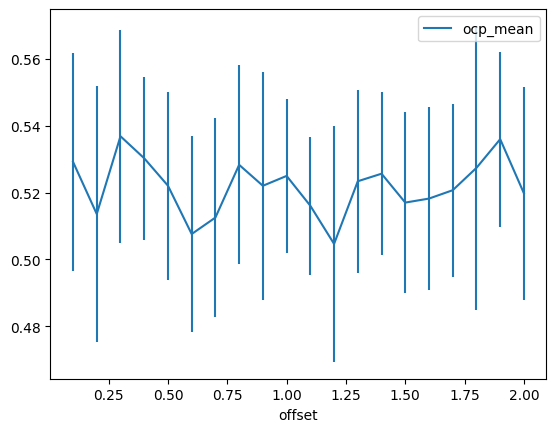

In [11]:
%matplotlib inline
df[df.j == False].plot(y = "ocp_mean",x = "offset", yerr = "ocp_sd")

<AxesSubplot: xlabel='offset'>

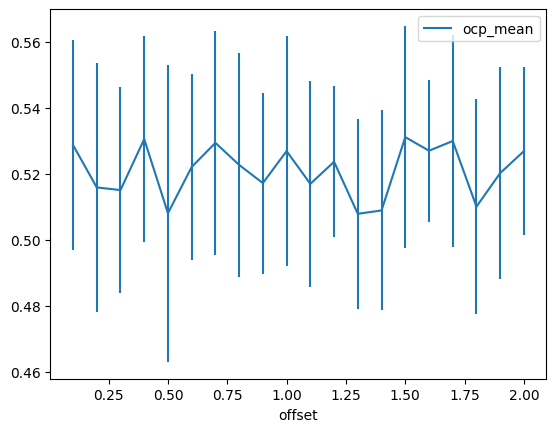

In [12]:
df[df.j == True].plot(y = "ocp_mean", x = "offset", yerr = "ocp_sd")

We plot mean values of median MSE, with standard deviation. Here the difference in results is clearly dwarfed by the error bars: It does not matter at all which values we pick. 

<AxesSubplot: xlabel='offset'>

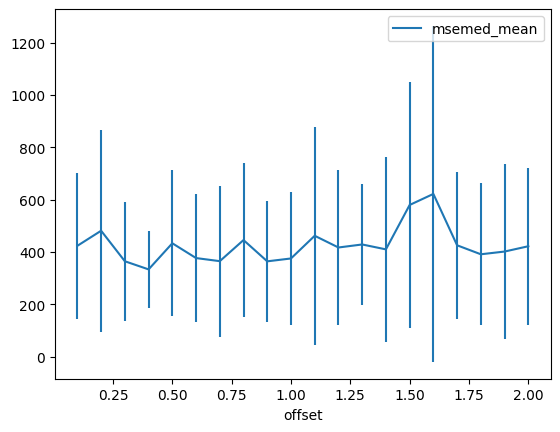

In [13]:
df[df.j == False].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

<AxesSubplot: xlabel='offset'>

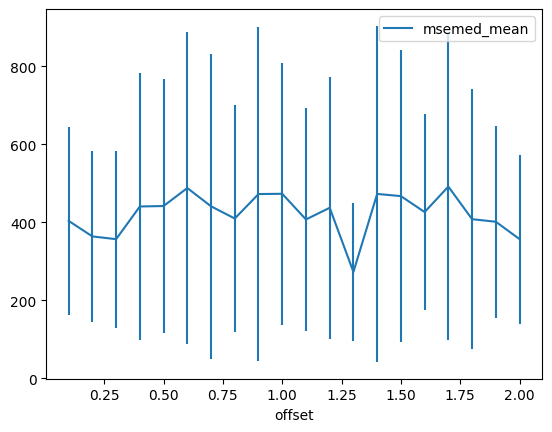

In [14]:
df[df.j == True].plot(y = "msemed_mean", x = "offset", yerr = "msemed_sd")

### Parameters for seeds as words

Because we need to pick some value, we pick the best OC_P, which also has a decent MSE: **offset of 0.3, no jitter**. 

In [15]:
df.sort_values(by = "ocp_mean", ascending = False).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
22,0.3,False,0.536805,0.031807,364.586157,227.911690
38,1.9,False,0.535934,0.026170,401.689149,332.955032
14,1.5,True,0.531174,0.033680,466.935874,374.464350
3,0.4,True,0.530575,0.031314,440.331132,342.837467
23,0.4,False,0.530226,0.024316,333.561137,146.967479
16,1.7,True,0.529989,0.031976,491.359028,392.518528
6,0.7,True,0.529428,0.034039,440.814201,390.238613
20,0.1,False,0.529162,0.032603,423.632728,279.087966
0,0.1,True,0.528786,0.031751,403.440277,241.692239
27,0.8,False,0.528270,0.029734,445.541672,294.049015


In [16]:
df.sort_values(by = "msemed_mean", ascending = True).head(10)

,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
12,1.3,True,0.507939,0.028688,272.517654,177.800588
23,0.4,False,0.530226,0.024316,333.561137,146.967479
2,0.3,True,0.515120,0.031178,356.532935,227.038393
19,2.0,True,0.526936,0.025539,356.723715,216.386196
1,0.2,True,0.515936,0.037784,363.614069,218.643055
28,0.9,False,0.522011,0.034021,364.313029,232.178649
22,0.3,False,0.536805,0.031807,364.586157,227.911690
26,0.7,False,0.512525,0.029851,364.985460,288.157101
29,1.0,False,0.524959,0.023101,375.271528,253.189576
25,0.6,False,0.507601,0.029139,376.801346,245.880319


## Fitted dimensions with seeds as dimensions: alpha, averaging

We first run an exploration, with only one random seed.

In [17]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.25, num=10)

results = defaultdict(list)

randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r)            



0.001 True 0.6278471497036935 15.78279080303528
0.028666666666666667 True 0.603959658707845 78.21562847539244
0.05633333333333333 True 0.5801455006154624 60.834795122631824
0.08399999999999999 True 0.5802412143000019 92.15933862927149
0.11166666666666666 True 0.5925515741231113 83.07753645644269
0.13933333333333334 True 0.5762517292120412 78.93000916777478
0.16699999999999998 True 0.5717589166096052 72.63937511826477
0.19466666666666665 True 0.5584187192444229 91.63265959014146
0.22233333333333333 True 0.5733309841259568 91.23033307337533
0.25 True 0.5477354327544911 73.71457092885866
0.001 False 0.6318003215596817 33.852672101217046
0.028666666666666667 False 0.5640595698533596 72.19889202545949
0.05633333333333333 False 0.5681154134296985 92.74741741995051
0.08399999999999999 False 0.5902349858884806 81.298944804499
0.11166666666666666 False 0.5737911308703103 91.56155148740231
0.13933333333333334 False 0.5736860273589964 92.17754690875327
0.16699999999999998 False 0.5526226845317244

In [18]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.627847,0.111819,45.306498,66.029746
1,0.028667,True,0.603960,0.094760,188.088451,283.380372
2,0.056333,True,0.580146,0.103405,147.178397,230.636877
3,0.084000,True,0.580241,0.101047,189.899073,233.389898
4,0.111667,True,0.592552,0.113677,135.747475,126.357413


<AxesSubplot: xlabel='alpha'>

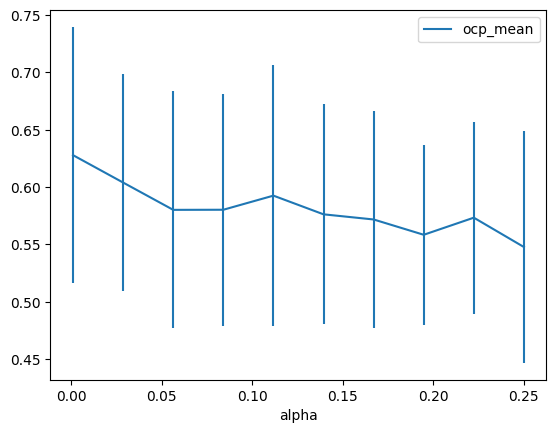

In [19]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

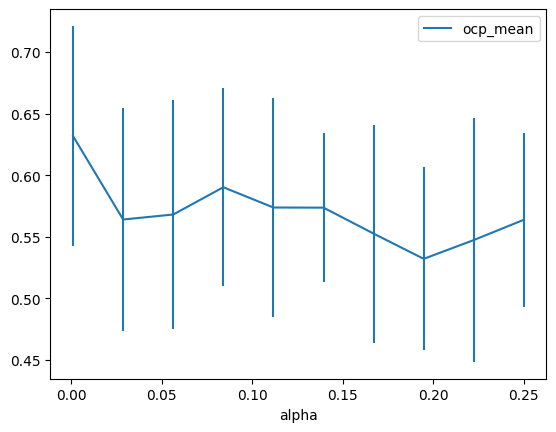

In [20]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

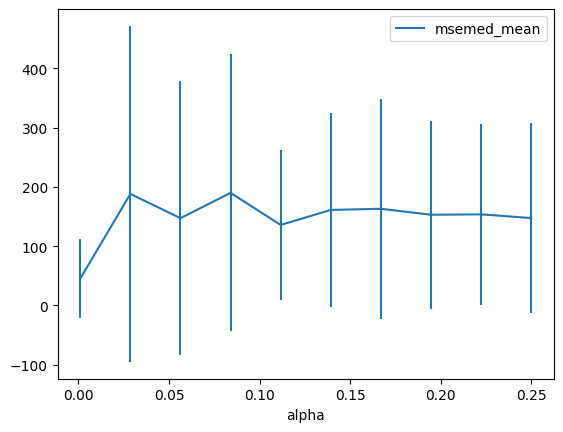

In [21]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

<AxesSubplot: xlabel='alpha'>

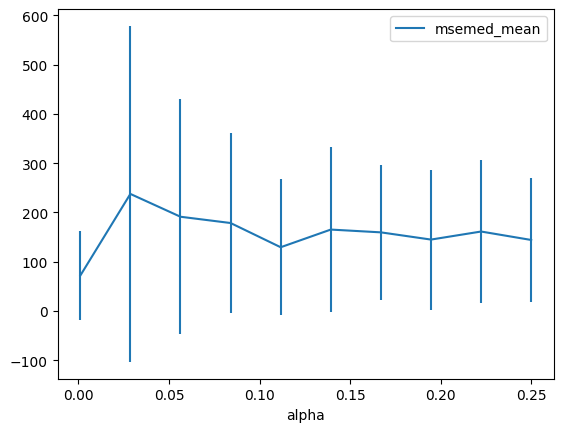

In [22]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "msemed_mean", yerr = "msemed_sd")

We see that overall the performance is best, in terms of both OC_P and MSE, for small values of alpha, though again there is a large error bar. We explore the low range of alpha in more detail, both with and without averaging. 

In [23]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.15, num=10)

results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            
            ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
            _, mse_med, _ = eval_summary_by(theseresults, "mse")
            print(alphaval, avgval, ocp_mean, mse_med)
            
            
            for r in theseresults:
                r.update({"alpha":alphaval, "avg": avgval})
                results[ (str(alphaval), str(avgval))].append(r) 

0.001 True 0.6455686842653541 22.488142126982545
0.017555555555555557 True 0.5839761374675158 88.00512326041157
0.03411111111111111 True 0.5617332420505806 123.30590522480709
0.050666666666666665 True 0.5387932883816794 100.29018071999835
0.06722222222222222 True 0.5678953847639777 151.21927549348663
0.08377777777777778 True 0.5746835249293486 92.82230421271001
0.10033333333333333 True 0.55368533624277 96.03650974492062
0.11688888888888889 True 0.5633742225539642 123.11962543391033
0.13344444444444445 True 0.5549827091088134 147.75322985231762
0.15 True 0.5682828324158938 185.8128197430657
0.001 False 0.6146431381120826 34.37810865734119
0.017555555555555557 False 0.5859416543538747 85.94455259801627
0.03411111111111111 False 0.5792321189328192 148.8629518223002
0.050666666666666665 False 0.5818502984810613 136.32433607148454
0.06722222222222222 False 0.5823307896683423 181.41017052347843
0.08377777777777778 False 0.5458423819453729 169.1302155754044
0.10033333333333333 False 0.5587890

In [24]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg"]))
df.head()


,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.635724,0.083686,52.833241,54.421707
1,0.017556,True,0.554351,0.066150,600.293530,1168.518620
2,0.034111,True,0.550495,0.056867,832.424318,1127.662658
3,0.050667,True,0.549376,0.064692,727.420266,1128.036333
4,0.067222,True,0.533032,0.045137,474.408191,667.767589


We again plot average OC_P mean and MSE median values, with error bars. 

<AxesSubplot: xlabel='alpha'>

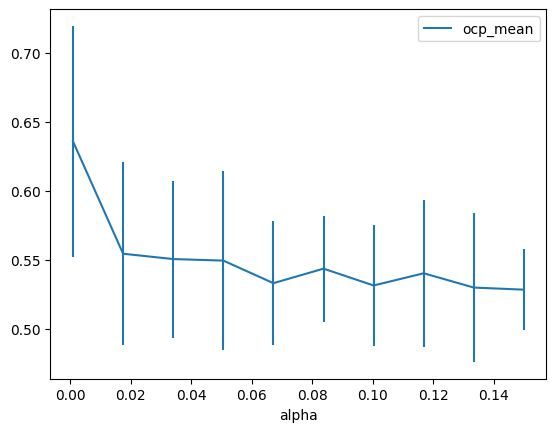

In [25]:
%matplotlib inline

df[df.avg == True].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

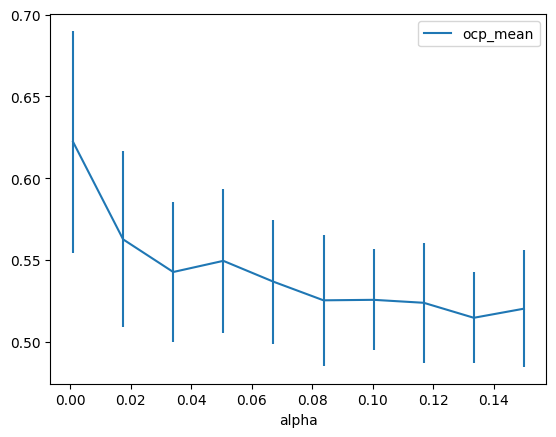

In [26]:
df[df.avg == False].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

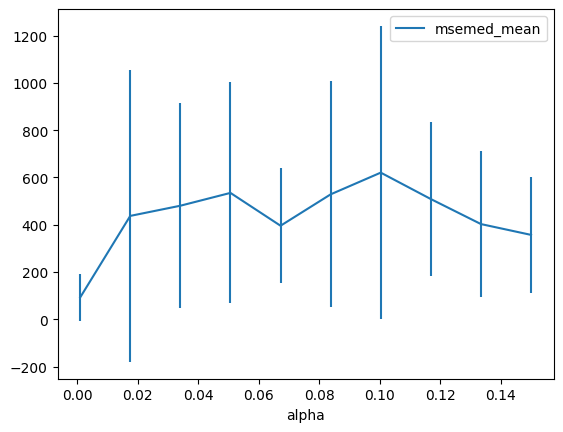

In [27]:
df[df.avg == False].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

<AxesSubplot: xlabel='alpha'>

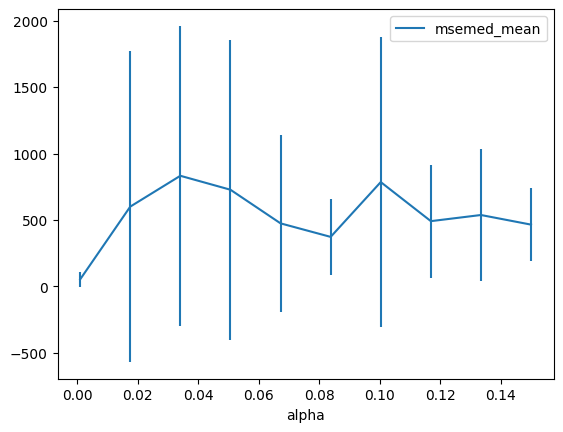

In [28]:
df[df.avg == True].plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

We again see large error bars, meaning that there is wide difference across sub-datasets. Still, the lowest values of alpha seem best both in terms of OC_P and MSE. 

We again look at the numbers.

In [29]:
df[df.avg == True].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.635724,0.083686,52.833241,54.421707
1,0.017556,True,0.554351,0.066150,600.293530,1168.518620
2,0.034111,True,0.550495,0.056867,832.424318,1127.662658


In [30]:
df[df.avg == False].sort_values(by = 'ocp_mean', ascending = False).head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.622190,0.067808,92.446764,100.757103
11,0.017556,False,0.562544,0.053802,437.525140,617.657020
13,0.050667,False,0.549408,0.044019,534.852996,467.747333


In [31]:
df[df.avg == False].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
10,0.001000,False,0.622190,0.067808,92.446764,100.757103
19,0.150000,False,0.520162,0.035613,357.224576,244.283059
14,0.067222,False,0.536670,0.037898,395.898717,243.458667


In [32]:
df[df.avg == True].sort_values(by = 'msemed_mean').head(3)

,alpha,avg,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.635724,0.083686,52.833241,54.421707
5,0.083778,True,0.543547,0.038368,372.606500,283.304364
9,0.150000,True,0.528318,0.029542,464.867714,276.297546


In terms of both OC_P and MSE, the best value is at **alpha = 0.001, with averaging over seeds.** 

# Combined model: seeds as words and dimensions

We fix jitter to be true, and averaging to be true, in order not to have too many conditions. We also fix offset to being 1.3, as before, as offset never makes much of a difference. We test different alpha values, with 3 random conditions. 

In [38]:
average_vals = [True]
alpha_vals= np.linspace(0.001, 0.15, num=10)
jitter_vals = [False]
offset_vals= [ 0.3 ]


results = defaultdict(list)

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    theseresults = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    
                    ocp_mean, _, _ = eval_summary_by(theseresults, "ocp")
                    _, mse_med, _ = eval_summary_by(theseresults, "mse")
                    print(alphaval, avgval, oval, jval, ocp_mean, mse_med)
            
            
                    for r in theseresults:
                        r.update({"alpha":alphaval, "avg": avgval, "offset": oval, "j": jval})
                        results[ (str(alphaval), str(avgval))].append(r) 




0.001 True 0.3 False 0.6560083933480119 3.30022209940826
0.017555555555555557 True 0.3 False 0.7296893314192134 2.3379330353432994
0.03411111111111111 True 0.3 False 0.7029774674474883 2.2250456602772974
0.050666666666666665 True 0.3 False 0.6826545184962305 3.0545522998578707
0.06722222222222222 True 0.3 False 0.6519583218013487 3.7137088079852605
0.08377777777777778 True 0.3 False 0.6403911928438616 6.10737974355083
0.10033333333333333 True 0.3 False 0.6214274374389887 7.484035039997099
0.11688888888888889 True 0.3 False 0.6239016505738751 7.381699762960373
0.13344444444444445 True 0.3 False 0.6218898914975167 8.40246071016826
0.15 True 0.3 False 0.6191058601650524 11.469374466697808
0.001 True 0.3 False 0.6906494242097775 3.4038125319590287
0.017555555555555557 True 0.3 False 0.6889234209093006 2.328303362974572
0.03411111111111111 True 0.3 False 0.6594104049442417 2.9750782746532467
0.050666666666666665 True 0.3 False 0.6139853066292409 3.787018011247433
0.06722222222222222 True 0.

In [39]:
df = pd.DataFrame(eval_hyper(results, ["alpha", "avg", "offset", "j"]))
df.head()


,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
0,0.001000,True,0.3,False,0.677664,0.092040,3.751759,2.005137
1,0.017556,True,0.3,False,0.719674,0.051736,1.974980,0.950628
2,0.034111,True,0.3,False,0.694799,0.053914,2.645923,1.546057
3,0.050667,True,0.3,False,0.662473,0.042189,3.864464,2.031372
4,0.067222,True,0.3,False,0.654404,0.047012,5.784824,5.169981


## Plotting the results



<AxesSubplot: xlabel='alpha'>

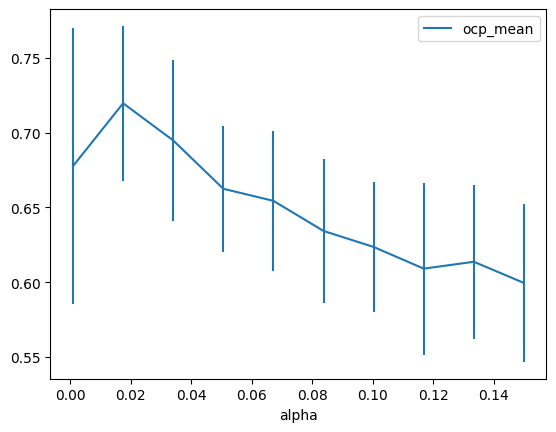

In [40]:
df.plot(y = "ocp_mean", x = "alpha", yerr = "ocp_sd")

<AxesSubplot: xlabel='alpha'>

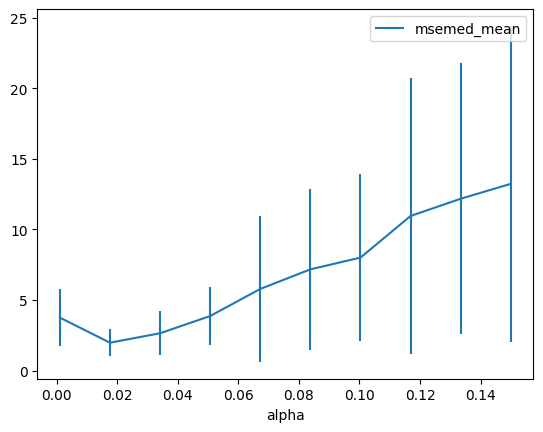

In [41]:
df.plot(y = "msemed_mean", x = "alpha", yerr = "msemed_sd")

In [42]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,alpha,avg,offset,j,ocp_mean,ocp_sd,msemed_mean,msemed_sd
1,0.017556,True,0.3,False,0.719674,0.051736,1.974980,0.950628
2,0.034111,True,0.3,False,0.694799,0.053914,2.645923,1.546057
0,0.001000,True,0.3,False,0.677664,0.092040,3.751759,2.005137
3,0.050667,True,0.3,False,0.662473,0.042189,3.864464,2.031372
4,0.067222,True,0.3,False,0.654404,0.047012,5.784824,5.169981


Both OC_P and MSE have a clear best value at **alpha = 0.02**. We use **averaging, no jitter, and an offset of 0.3**,